Everything on CPU

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, ELU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [211]:
tf.__version__

'2.15.0'

In [212]:
tf.random.set_seed(2024)

In [213]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [214]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [215]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [216]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [217]:
train_price.shape, test_price.shape

((1016, 41), (269, 41))

In [218]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [219]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


In [220]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.013959,0.100755,0.169548,0.251664,0.429280,0.069447,...,0.016829,0.490880,0.029139,0.324387,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003311,0.105064,0.177072,0.242479,0.415421,0.069170,...,0.007411,0.499854,0.019105,0.311892,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.232479,0.412488,0.061482,...,0.006851,0.517925,0.012021,0.303981,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004506,0.120639,0.181054,0.216559,0.409791,0.051458,...,0.000000,0.539547,0.008036,0.297443,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.032780,0.131367,0.187847,0.208864,0.419323,0.052887,...,0.000213,0.566854,0.008782,0.300046,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.062710,0.139578,0.178564,0.201452,0.420097,0.056054,...,0.002047,0.569700,0.009469,0.304128,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.061864,0.144239,0.165171,0.203834,0.430032,0.054294,...,0.004082,0.569046,0.004827,0.296455,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.061828,0.142693,0.157912,0.216265,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272436,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.063943,0.142578,0.153651,0.230493,0.420234,0.050776,...,0.027586,0.576559,0.002892,0.238750,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087248,0.146637,0.145950,0.244864,0.413457,0.048868,...,0.039572,0.581729,0.024220,0.222509,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [221]:
y_train[0]

array([[0.57375545, 0.39893146, 0.06437328, 0.34211954, 0.18468364,
        0.14757604, 0.15820193, 0.23146491, 0.39263385, 0.04239953,
        0.14298896, 0.35850345, 0.01814811, 0.11799181, 0.4457627 ,
        0.13601568, 0.4683892 , 0.22343829, 0.11143575, 0.07930505,
        0.08803631, 0.12720957, 0.69378078, 0.10246328, 0.18349875,
        0.16302742, 0.0300701 , 0.14386724, 0.36465103, 0.18063451,
        0.21958413, 0.08440268, 0.57910612, 0.09897563, 0.25675073,
        0.17241916, 0.89049421, 0.77154303, 0.88986581, 0.06280436,
        0.07818394]])

In [222]:
X_train[0]

array([[5.41517497e-01, 4.61622419e-01, 3.46256104e-02, 2.57119733e-01,
        1.39587005e-02, 1.00754654e-01, 1.69547805e-01, 2.51663737e-01,
        4.29279557e-01, 6.94473107e-02, 2.34611053e-01, 3.70297457e-01,
        6.63307122e-02, 1.01872065e-01, 3.91173342e-01, 1.35496571e-01,
        4.08123162e-01, 2.37500855e-01, 1.63170999e-01, 1.17300197e-01,
        7.13347407e-02, 5.41255155e-02, 6.56006825e-01, 6.92384440e-02,
        1.95977993e-01, 1.17170024e-01, 8.86390227e-02, 1.56268167e-01,
        2.09577475e-01, 1.72731754e-01, 3.18454540e-01, 1.68289004e-02,
        4.90879943e-01, 2.91390213e-02, 3.24387023e-01, 1.73635728e-01,
        8.52898807e-01, 8.99365736e-01, 8.31755515e-01, 4.92100648e-02,
        6.70798906e-02],
       [5.29200994e-01, 4.61798844e-01, 3.42617711e-02, 2.78435479e-01,
        3.31113585e-03, 1.05064495e-01, 1.77071786e-01, 2.42479285e-01,
        4.15420725e-01, 6.91696514e-02, 2.15920869e-01, 3.64839847e-01,
        6.54307025e-02, 9.24787579e-02,

In [223]:
X_train.shape

(1001, 15, 41)

Everything matches. Each row of my dataset is an element of the arrays: 1001 samples where each sample has 15 timesteps for each of the 41 stocks. The sequences are ready for training.

### Functions

In [224]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

# aggregated metrics
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())


# metrics for each stock
def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df

## Sequence-2-Sequence Modeling (many-to-many) with LSTMs:
Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- RepeatVector layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via TimeDistributed wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

### LSTM

In [225]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

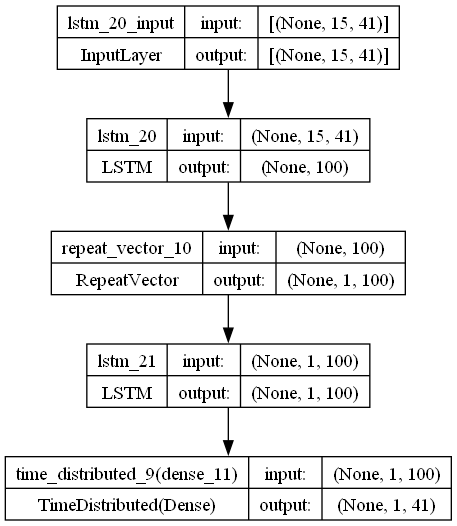

In [226]:
plot_model(model=model_enc_dec, show_shapes=True)

In [227]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 3s 9ms/step - loss: 0.1560
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0082
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0065
Epoch 6/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 10/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 11/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 12/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 13/50
32/32 [==============================] - 0s 1

In [228]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [229]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [230]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 7.4344935
mse: 163.45354
mape: 13.281309


In [231]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [232]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [233]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,19.685282,555.501038,16.030663
1,ENGI FP Equity,1.113385,1.859598,8.152891
2,BAYN GY Equity,30.215124,1122.348999,27.581516
3,BNP FP Equity,4.445480,23.456907,7.067376
4,PHIA NA Equity,0.947650,1.486168,3.167061
5,ISP IM Equity,0.162674,0.040626,5.971813
6,SAN FP Equity,7.175575,66.271034,8.663924
7,MC FP Equity,30.227814,1242.451538,13.097553
8,ENEL IM Equity,0.385966,0.251553,7.583021
9,CS FP Equity,7.185721,65.776871,29.088587


In [234]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

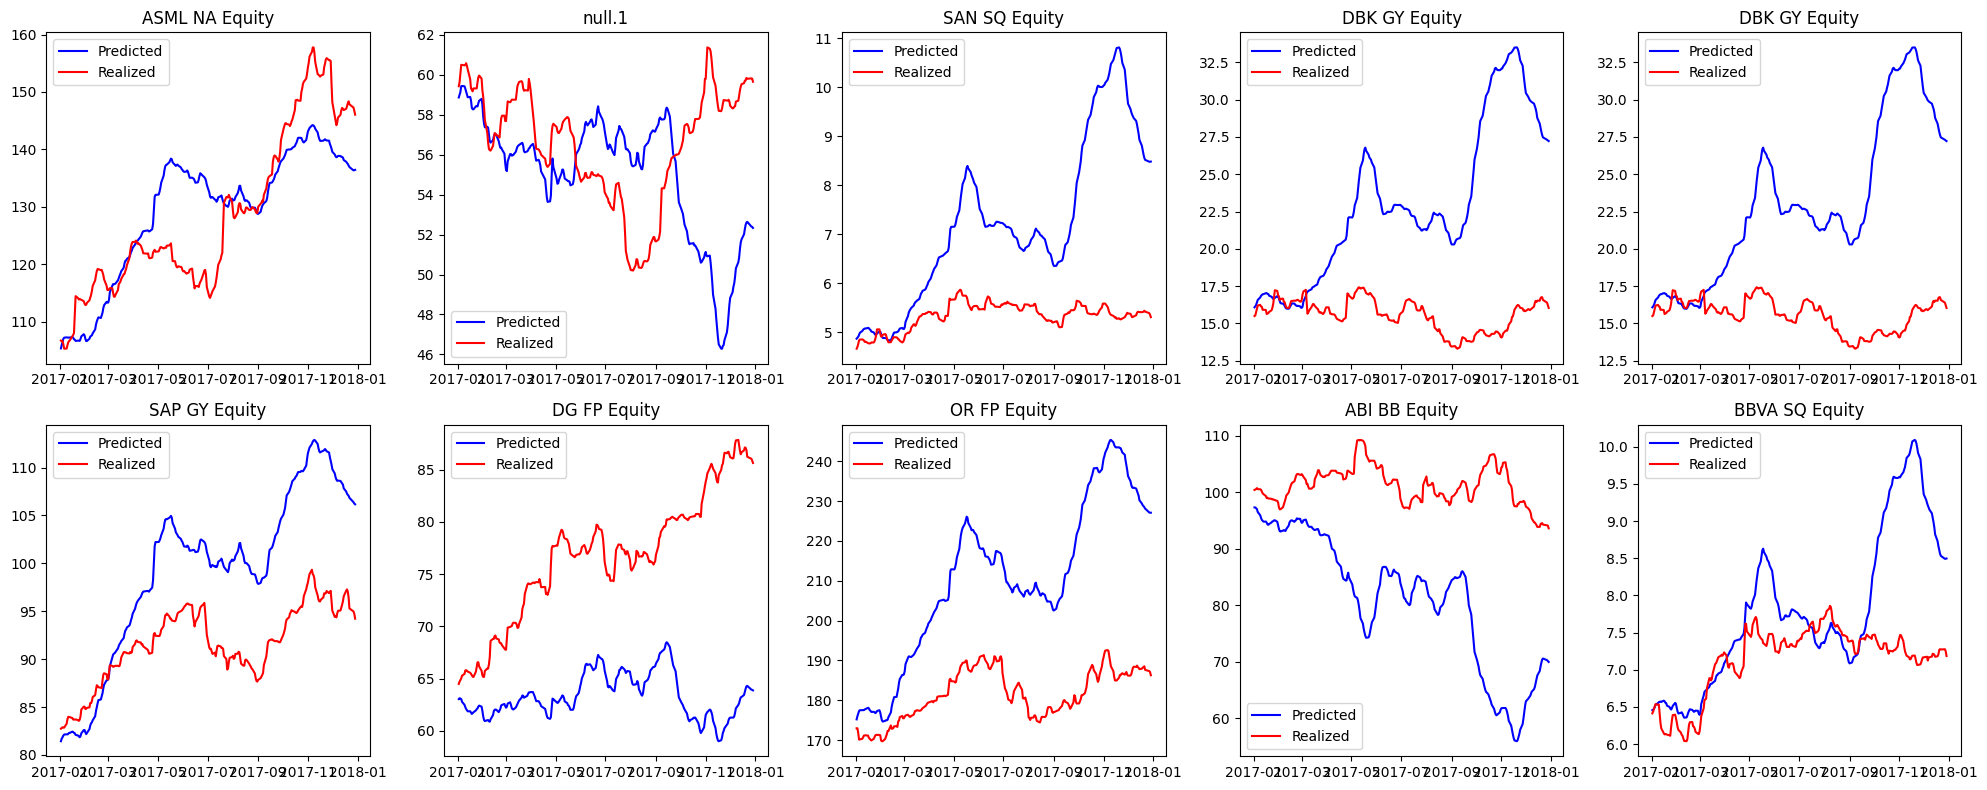

In [235]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN encoder - LSTM decoder

In [236]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

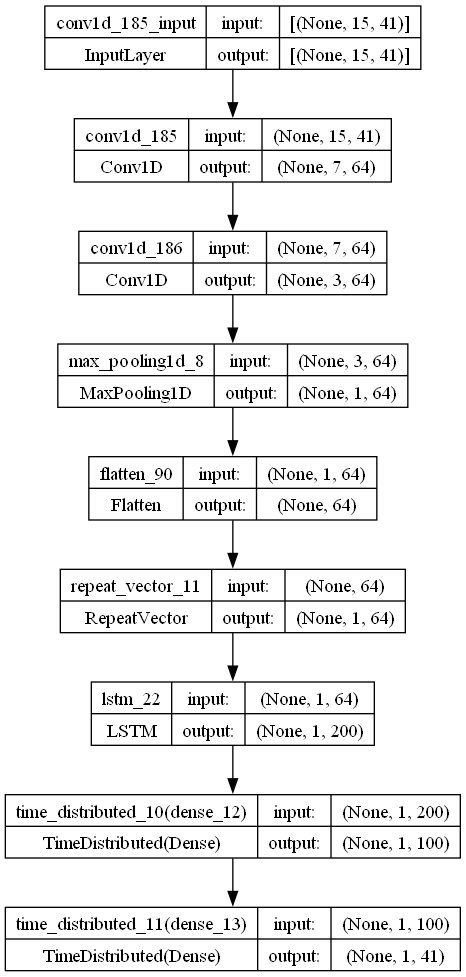

In [237]:
plot_model(model=cnn_lstm, show_shapes=True)

In [238]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 5ms/step - loss: 0.1219
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0095
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 11/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 12/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 13/50
32/32 [==============================

In [239]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [240]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [241]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.470369
mse: 66.40556
mape: 7.498695


In [242]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [243]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,7.520039,103.512054,5.830355
1,ENGI FP Equity,1.442064,2.471238,10.452285
2,BAYN GY Equity,6.541873,64.490120,5.930192
3,BNP FP Equity,3.334739,16.287685,5.374854
4,PHIA NA Equity,1.275707,2.591173,4.273638
5,ISP IM Equity,0.163938,0.036594,6.030500
6,SAN FP Equity,4.284807,24.270929,5.276962
7,MC FP Equity,28.719709,1068.131348,12.505489
8,ENEL IM Equity,0.558846,0.456718,11.107959
9,CS FP Equity,1.935344,4.441681,7.955209


In [244]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

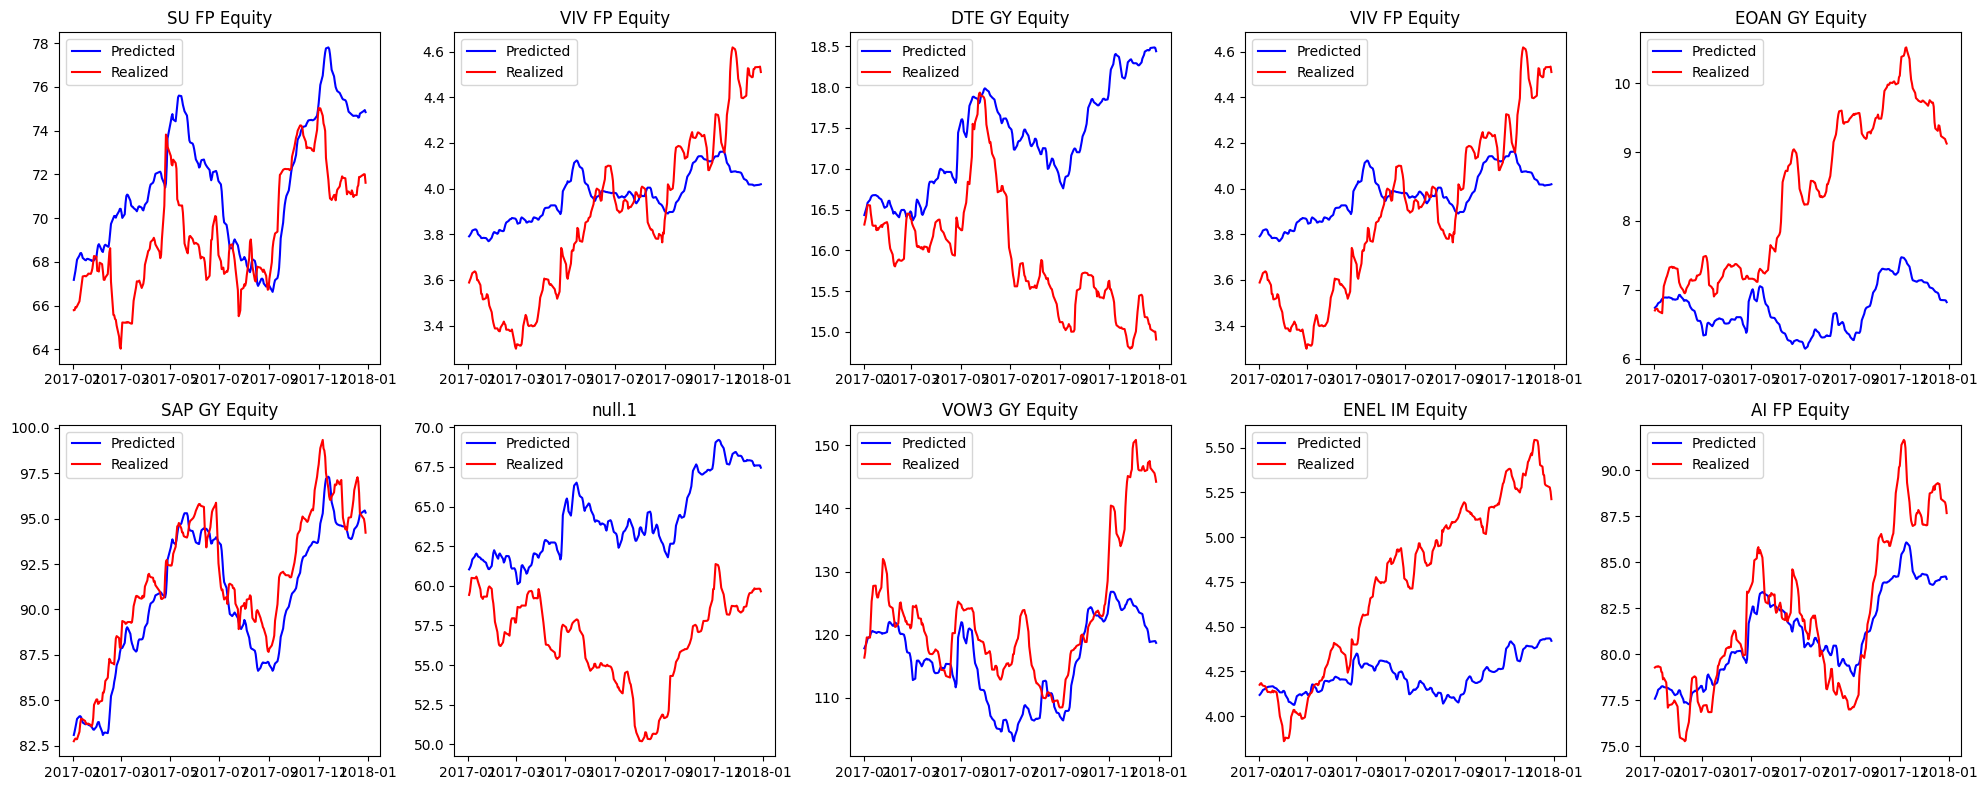

In [245]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### Multi-Head CNN-LSTM

The multi-head structure uses multiple one-dimensional CNN layers in order to process each time series and extract independent convolved features from each time series. These separate CNNs are called “head” and flattened, concatenated, and reshaped respectively before feeding into the LSTM layer. Therefore, they might be more successful to keep significant features of each time series and make better forecasts in this sense.

In [246]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts :)
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

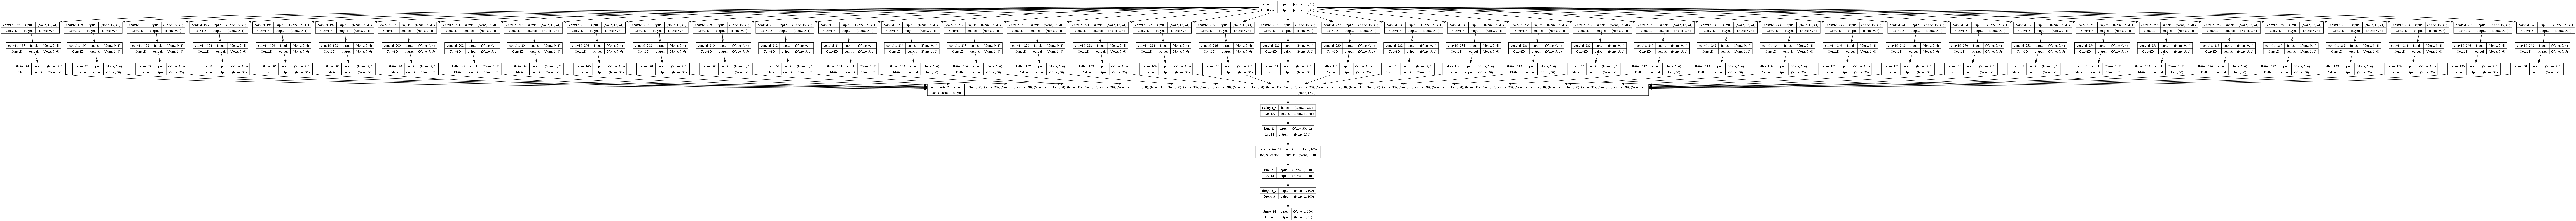

In [247]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)

In [248]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=70, batch_size=32)
# 70 epochs to reach global minimum

Epoch 1/70
32/32 [==============================] - 18s 27ms/step - loss: 0.1767
Epoch 2/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0596
Epoch 3/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0457
Epoch 4/70
32/32 [==============================] - 1s 28ms/step - loss: 0.0321
Epoch 5/70
32/32 [==============================] - 1s 29ms/step - loss: 0.0260
Epoch 6/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0237
Epoch 7/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0212
Epoch 8/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0196
Epoch 9/70
32/32 [==============================] - 1s 31ms/step - loss: 0.0184
Epoch 10/70
32/32 [==============================] - 1s 30ms/step - loss: 0.0169
Epoch 11/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0164
Epoch 12/70
32/32 [==============================] - 1s 30ms/step - loss: 0.0152
Epoch 13/70
32/32 [=================

In [249]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [250]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [251]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.3352733
mse: 61.874523
mape: 7.3613095


In [252]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,8.990280,162.327866,6.874532
1,ENGI FP Equity,1.427179,3.045445,10.183639
2,BAYN GY Equity,8.142939,82.626747,7.384768
3,BNP FP Equity,2.457407,9.201584,3.850040
4,PHIA NA Equity,1.617010,3.998819,5.315731
5,ISP IM Equity,0.229145,0.072255,8.298231
6,SAN FP Equity,4.797954,29.872227,5.791504
7,MC FP Equity,26.602180,900.602539,11.593231
8,ENEL IM Equity,0.452609,0.316657,8.963017
9,CS FP Equity,0.493461,0.420309,2.066293


In [253]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

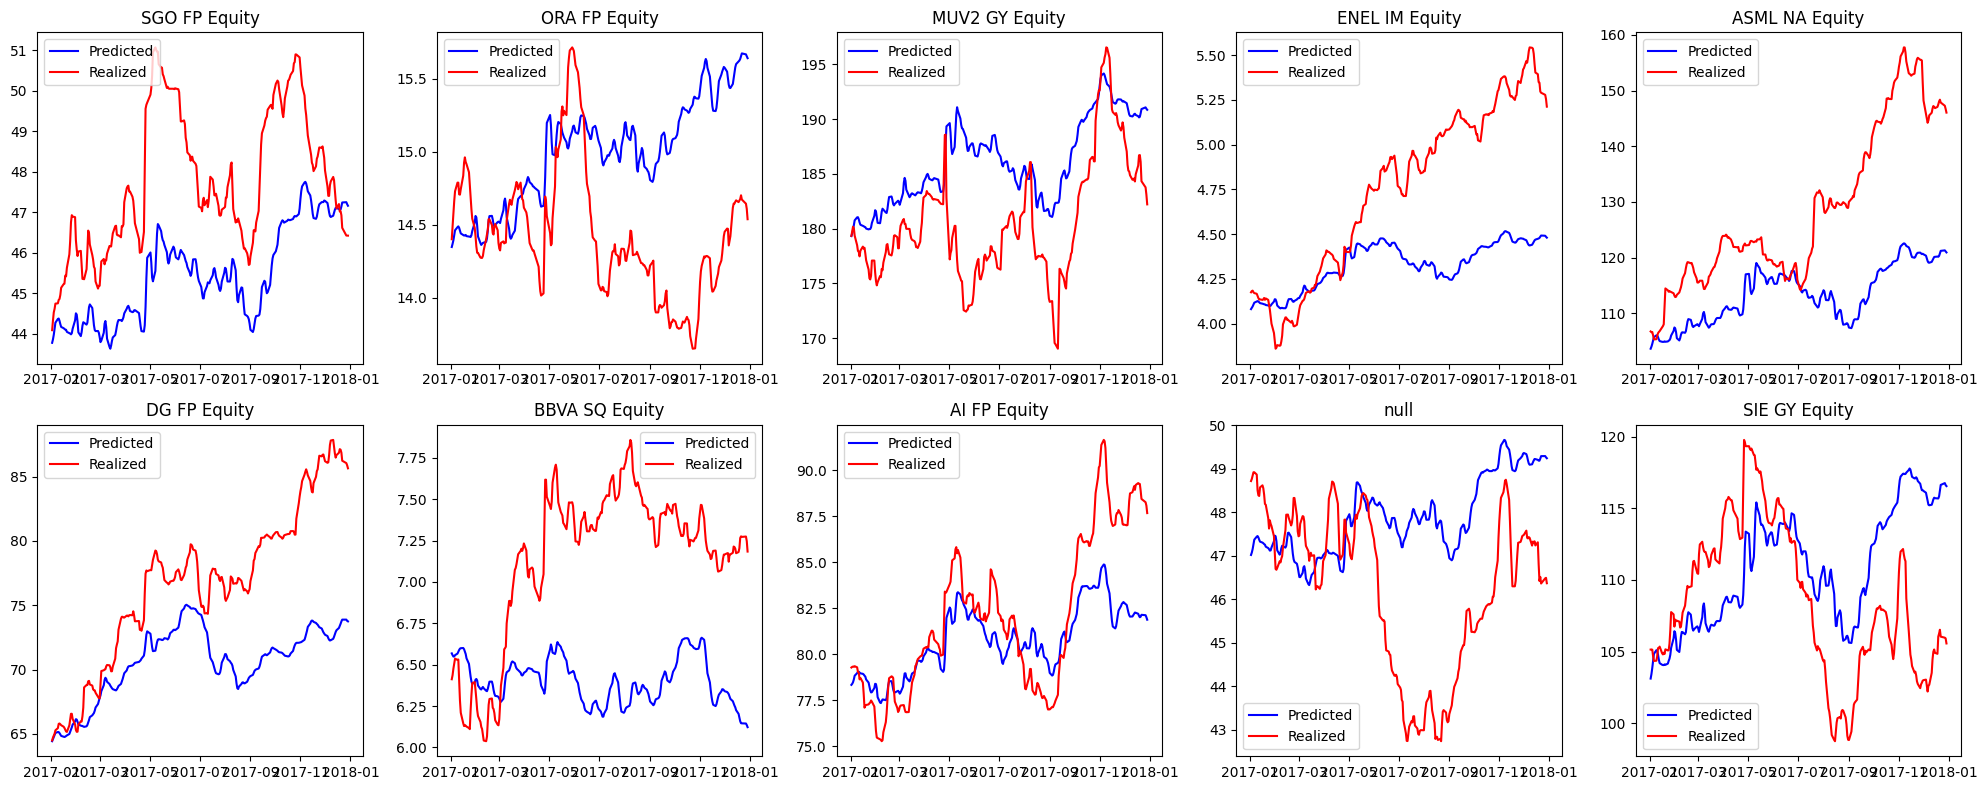

In [254]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-BiLSTM

In [ ]:
plot_model(model=cnn_bilstm, show_shapes=True)

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [257]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [258]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)
metrics_df

In [261]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

#### Could save the predictions of the model(s) in a pickle file and load them on an ptf_optimization.ipynb notebook

----------------

### DO NOT CONSIDER CODE BELOW

In [263]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

AttributeError: 'numpy.ndarray' object has no attribute 'shift'

In [ ]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [ ]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------